# Gravitational Lensing

Weak gravitational lensing distorts the images of distant galaxies as their light passes through foreground matter. The convergence field $\kappa$ measures the projected mass along the line of sight, weighted by a lensing efficiency kernel.

This notebook computes convergence maps from PM lightcones using two methods:

| Method | Function | JAX-compatible | Accuracy |
|--------|----------|---------------|----------|
| **Born approximation** | `born()` | Yes (JIT-able) | First-order |
| **Ray-tracing** | `raytrace()` | No (uses dorian/NumPy) | Full post-Born |

The Born approximation integrates the lensing potential along unperturbed light paths. Ray-tracing propagates the full distortion matrix through each lens plane, capturing lens-lens coupling and other post-Born effects.

## Setup

In [1]:
import os

os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.97'
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

import jax
import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pyplot as plt

import fwd_model_tools as ffi
from jax.sharding import Mesh, NamedSharding, PartitionSpec as P, AxisType
jax.config.update('jax_enable_x64' , False)


print(f"Number of devices: {jax.device_count()}")
print(f"Devices {jax.devices()}")
jax.print_environment_info()

mesh = jax.make_mesh((4 , 1) , ('x', 'y') , axis_types=(AxisType.Auto , AxisType.Auto))
sharding = NamedSharding(mesh, P('x', 'y'))

/lustre/fswork/projects/rech/tkc/commun/venv/pm/lib/python3.11/site-packages/jax/_src/compiler.py:783: UserWarning: Error reading persistent compilation cache entry for 'jit_convert_element_type': PermissionError: [Errno 13] Permission denied: '/jax_cache'
  warnings.warn(


Number of devices: 4
Devices [CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]
jax:    0.9.0.1
jaxlib: 0.9.0.1
numpy:  2.4.2
python: 3.11.5 | packaged by conda-forge | (main, Aug 27 2023, 03:34:09) [GCC 12.3.0]
device info: NVIDIA H100 80GB HBM3-4, 4 local devices"
process_count: 1
platform: uname_result(system='Linux', node='jzxh185', release='5.14.0-570.58.1.el9_6.x86_64', version='#1 SMP PREEMPT_DYNAMIC Tue Oct 21 04:15:07 EDT 2025', machine='x86_64')
JAX_PERSISTENT_CACHE_ENABLE_XLA_CACHES=xla_gpu_per_fusion_autotune_cache_dir
JAX_PERSISTENT_CACHE_MIN_ENTRY_SIZE_BYTES=-1
JAX_COMPILATION_CACHE_DIR=/jax_cache
JAX_PERSISTENT_CACHE_MIN_COMPILE_TIME_SECS=0
XLA_PYTHON_CLIENT_MEM_FRACTION=0.97

$ nvidia-smi
Wed Feb 18 15:06:55 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.126.16             Driver Version: 580.126.16     CUDA Version: 13.0     |
+-----------------------------------------+-----

## Run PM Simulation with Spherical Output

We need a spherical lightcone (`SphericalDensity` with `status=LIGHTCONE`) as input for both lensing functions.

In [2]:
key = jax.random.PRNGKey(0)
mesh_size = (1000, 1000 , 1000)
box_size = (3000.0, 3000.0, 3000.0)
nside = 1024
nb_shells = 8
cosmo = jc.Planck18()

initial_field = ffi.gaussian_initial_conditions(
    key, mesh_size, box_size,
    cosmo=cosmo,
    nside=nside,
    sharding=sharding
)

dx, p = ffi.lpt(cosmo, initial_field, ts=0.1, order=1)

solver = ffi.ReversibleDoubleKickDrift(
    interp_kernel=ffi.OnionTiler(painting=ffi.PaintingOptions(target="spherical", scheme="bilinear"), drift_on_lightcone=True),
)
lightcone = ffi.nbody(
    cosmo, dx, p,
    t1=1.0, dt0=0.05,
    nb_shells=nb_shells,
    solver=solver,
)

print(f"Lightcone shape: {lightcone.shape}")
print(f"Scale factors: {lightcone.scale_factors}")

Lightcone shape: (8, 12582912)
Scale factors: [0.96952313 0.9125213  0.8601795  0.8118675  0.76705426 0.72529256
 0.6862064  0.6494787 ]


## Redshift Distributions

Lensing convergence is computed for specific source galaxy populations. The `nz_shear` parameter defines the redshift distribution $n(z)$ of source galaxies. We can use:
- `tophat_z(zmin, zmax)`: simple top-hat distribution
- `get_stage3_nz_shear()`: realistic 4-bin tomographic distributions from Stage 3 surveys

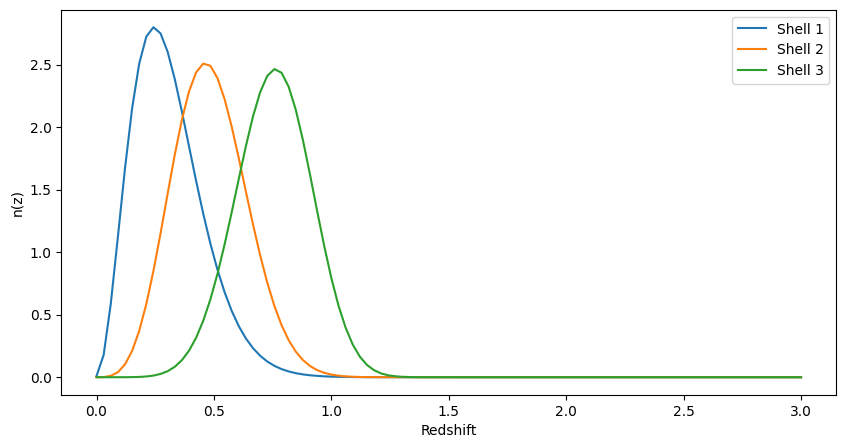

In [3]:
# Simple top-hat distributions at two redshifts
nz_sources = ffi.io.get_stage3_nz_shear()[:-1]

figure = plt.figure(figsize=(10, 5))

z_bins = jnp.linspace(0.0, 3.0, 100)

for i in range(len(nz_sources)):
    nz = nz_sources[i](z_bins)
    plt.plot(z_bins, nz, label=f"Shell {i+1}")

plt.xlabel("Redshift")
plt.ylabel("n(z)")
plt.legend()
plt.show()

## Born Approximation

The Born approximation is fast and fully differentiable (JIT-compatible). It integrates the weighted projected density along straight (unperturbed) light paths.

Born kappa type: SphericalKappaField
Born kappa shape: (3, 12582912)


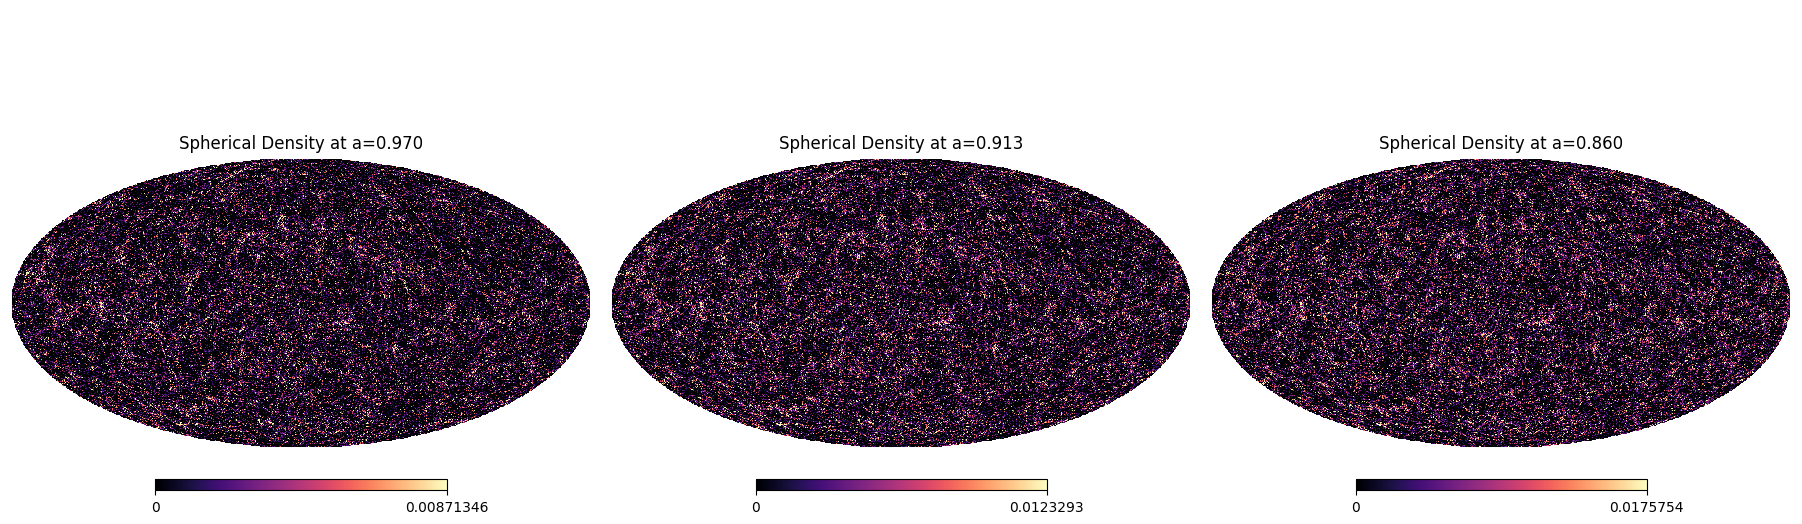

In [4]:
kappa_born = ffi.born(cosmo, lightcone, nz_shear=nz_sources)

print(f"Born kappa type: {type(kappa_born).__name__}")
print(f"Born kappa shape: {kappa_born.shape}")
kappa_born.show(ncols=3)

## Ray-tracing

Full ray-tracing propagates the distortion matrix through each lens plane, capturing post-Born corrections. This requires the `dorian` library (`pip install fwd-model-tools[raytrace]`) and cannot be JIT-compiled.

In [ ]:
kappa_dorian_born = ffi.raytrace(cosmo, lightcone,  nz_shear=nz_sources , born=True)
kappa_dorian_rt = ffi.raytrace(cosmo, lightcone,  nz_shear=nz_sources , born=False)


    ▐▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▌
    ▐                                                               ▌
    ▐   ██████████                       ███                        ▌
    ▐  ░░███░░░░███                     ░░░                         ▌
    ▐   ░███   ░░███  ██████  ████████  ████   ██████   ████████    ▌
    ▐   ░███    ░███ ███░░███░░███░░███░░███  ░░░░░███ ░░███░░███   ▌
    ▐   ░███    ░███░███ ░███ ░███ ░░░  ░███   ███████  ░███ ░███   ▌
    ▐   ░███    ███ ░███ ░███ ░███      ░███  ███░░███  ░███ ░███   ▌
    ▐   ██████████  ░░██████  █████     █████░░████████ ████ █████  ▌
    ▐  ░░░░░░░░░░    ░░░░░░  ░░░░░     ░░░░░  ░░░░░░░░ ░░░░ ░░░░░   ▌
    ▐                                                               ▌
    ▐▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▌
    


/lustre/fswork/projects/rech/tkc/commun/venv/pm/lib/python3.11/site-packages/dorian/raytracing.py:187: RuntimeWarning: divide by zero encountered in divide
  alpha_factor = np.where(alpha_factor == 0, 0, - 2 / alpha_factor) # Avoid division by zero at ell=0
/lustre/fswork/projects/rech/tkc/commun/venv/pm/lib/python3.11/site-packages/dorian/raytracing.py:190: RuntimeWarning: divide by zero encountered in divide
  fl_factor = np.where(fl_factor == 0, 0, 1 / fl_factor) # Avoid division by zero at ell=0


/tmp/ipykernel_553196/1506652267.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


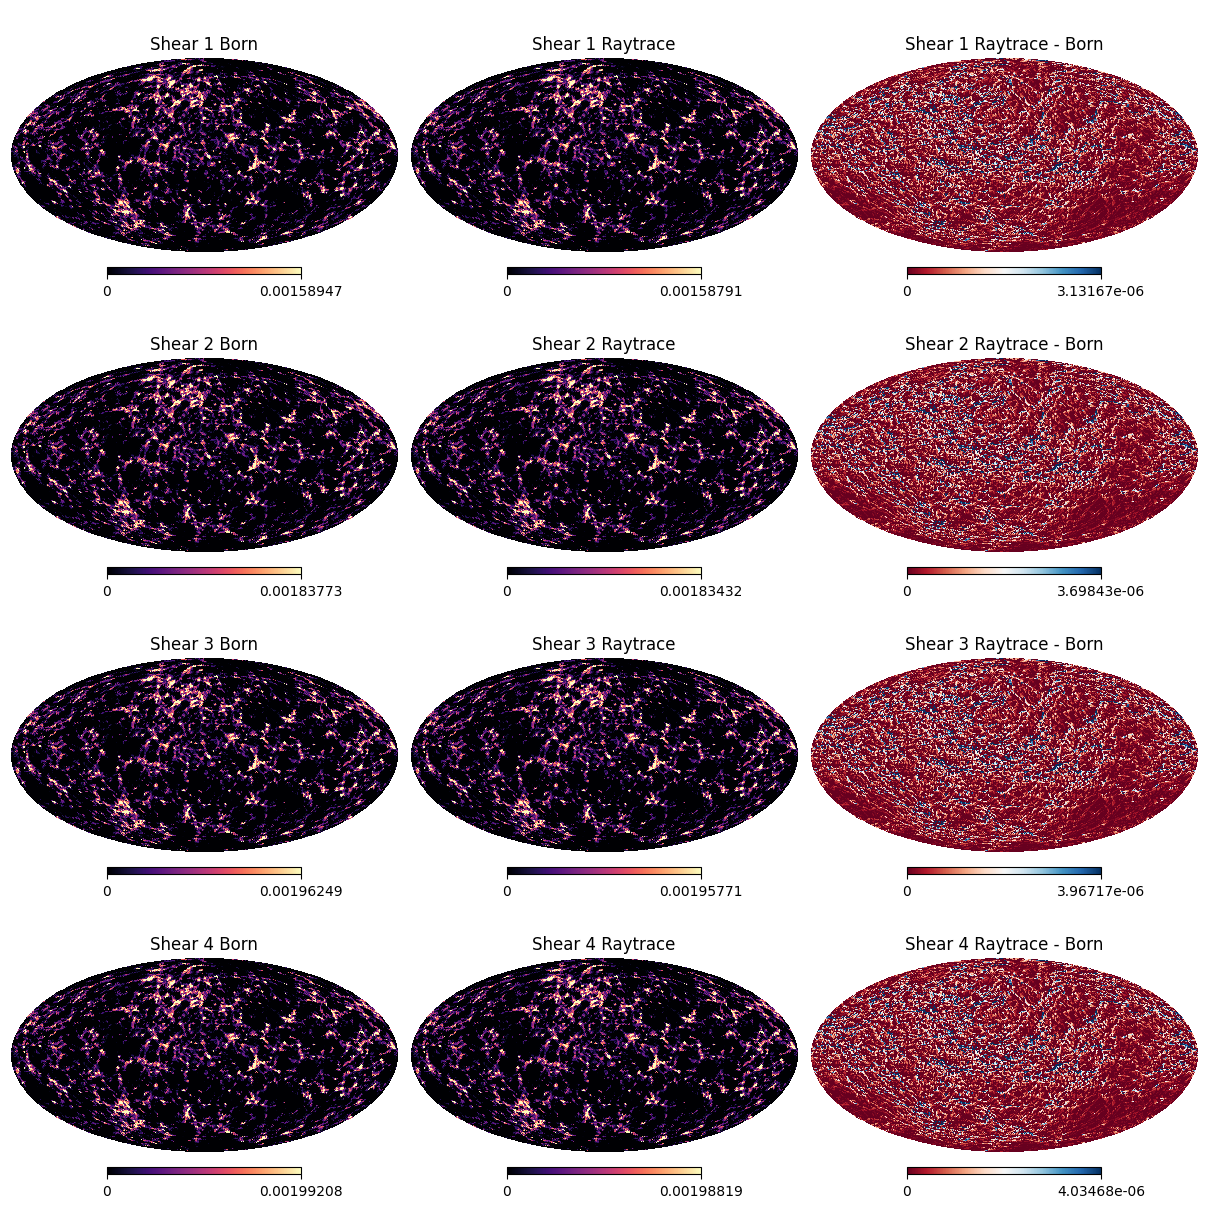

In [ ]:
fig , axs = plt.subplots(4, 3, figsize=(12, 12))

kappa_dorian_born.plot(ax=axs[:, 0], titles=[f"Shear {i+1} Born" for i in range(len(nz_sources))])
kappa_dorian_rt.plot(ax=axs[:, 1], titles=[f"Shear {i+1} Raytrace" for i in range(len(nz_sources))])
(kappa_dorian_rt - kappa_dorian_born).plot(ax=axs[:, 2], titles=[f"Shear {i+1} Raytrace - Born" for i in range(len(nz_sources))] , cmap="RdBu")
axs[3, 0].axis('off')
axs[3, 1].axis('off')
axs[3, 2].axis('off')
plt.tight_layout()
plt.show()

## Theory Comparison

Compare measured convergence power spectra against the theoretical prediction from `compute_theory_cl` with `probe_type="weak_lensing"`.

In [ ]:
LMAX = 3 * nside - 1
ells = jnp.arange(LMAX)

theory_cl = ffi.compute_theory_cl(
    cosmo, ell=ells, z_source=nz_sources,
    probe_type="weak_lensing", nonlinear_fn=jc.power.halofit, cross=False,
)

# Born power spectra
cl_born = kappa_born.angular_cl(method="healpy")
cl_rt = kappa_dorian_rt.angular_cl(method="healpy")
cl_dorian_born = kappa_dorian_born.angular_cl(method="healpy")


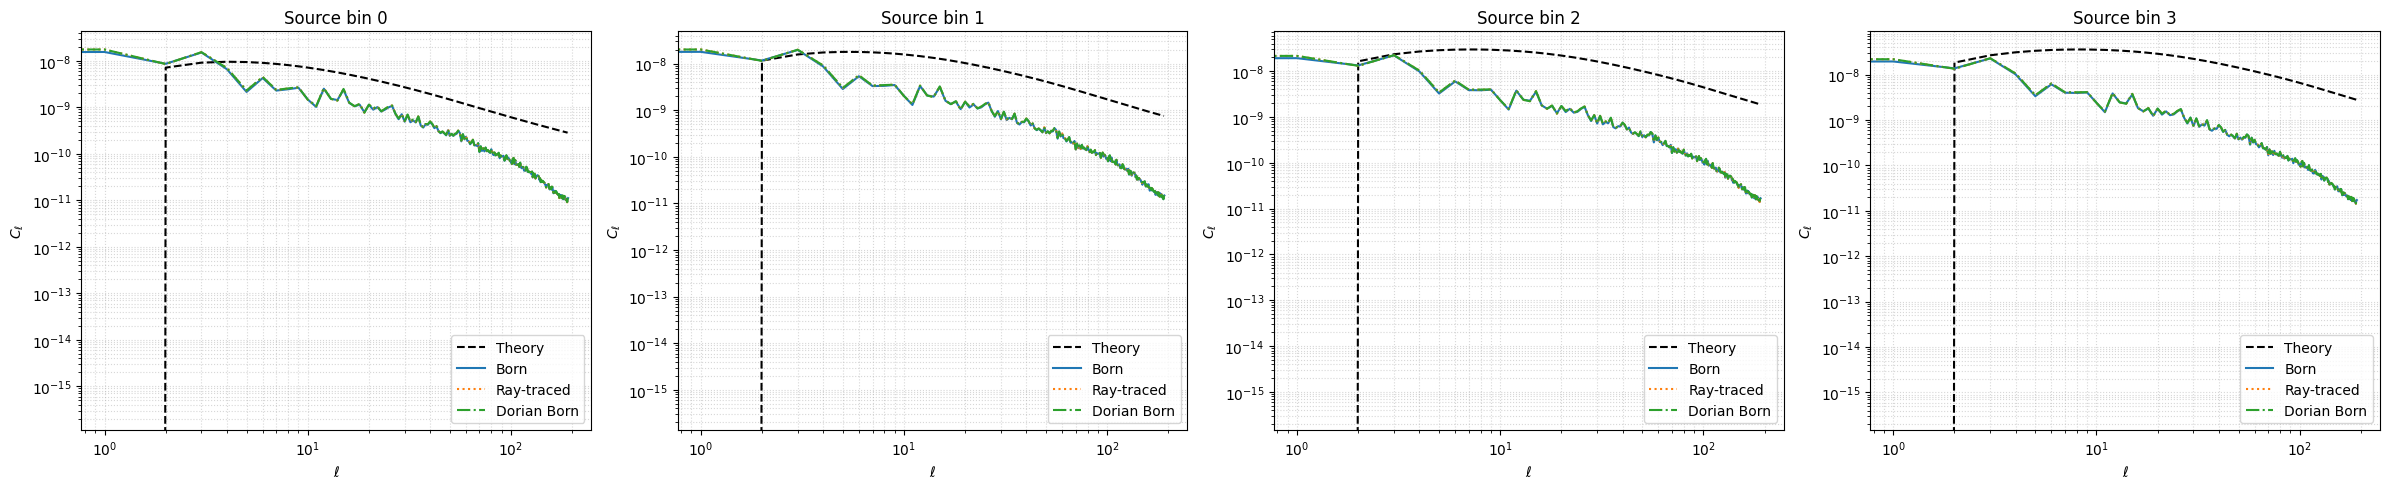

In [ ]:

n_sources = len(nz_sources)
fig, axes = plt.subplots(1, n_sources, figsize=(6 * n_sources, 5))
if n_sources == 1:
    axes = [axes]

for i in range(n_sources):
    theory_cl[i].plot(ax=axes[i], logx=True, logy=True, label=["Theory"], color="black", linestyle="--")
    cl_born[i].plot(ax=axes[i], logx=True, logy=True, label=["Born"], color="tab:blue")

    cl_rt[i].plot(ax=axes[i], logx=True, logy=True, label=["Ray-traced"], color="tab:orange" , linestyle=":")
    cl_dorian_born[i].plot(ax=axes[i], logx=True, logy=True, label=["Dorian Born"], color="tab:green" , linestyle="-.")

    axes[i].set_title(f"Source bin {i}")
    axes[i].legend()

plt.tight_layout()
plt.show()

## Born vs Ray-tracing Difference

Quantify the post-Born corrections by comparing the two convergence maps directly.